# Installs and Imports

In [1]:
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [16]:
import graphviz
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import json
import pandas as pd


In [17]:
import json
import networkx as nx

# Load the JSON data from the file
file_path = 'graph-pattern-1-top-1.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Create an empty graph
G = nx.Graph()

# Add nodes and edges from the JSON data
for item in data:
    if "vertex" in item:
        vertex = item["vertex"]
        G.add_node(vertex["id"], label=vertex["attributes"]["label"], timestamp=vertex["timestamp"])
    elif "edge" in item:
        edge = item["edge"]
        source = edge["source"]
        target = edge["target"]
        label = edge["attributes"]["label"]
        directed = edge["directed"] == "true"  # Check if the edge is directed
        timestamp = edge["timestamp"]

        # Add edge based on directed status
        if directed:
            G.add_edge(source, target, label=label, timestamp=timestamp, directed=True)
        else:
            G.add_edge(source, target, label=label, timestamp=timestamp, directed=False)

G  # Return the created graph object for review


In [18]:
import networkx as nx

def load_g_file_to_networkx(file_path):
    # Create an empty NetworkX graph
    G = nx.Graph()
    
    # Open the file and read line by line
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue  # Skip empty lines
            
            # Parse vertices (nodes) - lines starting with 'v'
            if parts[0] == 'v' and len(parts) > 2:
                node_id = parts[1]
                label = " ".join(parts[2:])
                G.add_node(node_id, label=label)
            
            # Parse edges - lines starting with 'e'
            elif parts[0] == 'e' and len(parts) > 3:
                source = parts[1]
                target = parts[2]
                label = " ".join(parts[3:])
                G.add_edge(source, target, label=label)
                
    return G

# Usage example
file_path = '../../output/graph.g'  # Replace with your .g file path
graph = load_g_file_to_networkx(file_path)

In [19]:
graph

# Statistics

## Support

In [20]:
import json

In [21]:
# Calculate max traces
with open('../../output/graph.g', 'r') as file:
    graph_content = file.readlines()

max_traces = sum(1 for line in graph_content if line.strip() == "XP")

max_traces

325

In [22]:
def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as f:
        return json.load(f)

def calculate_relative_support(pattern, max_traces):
    """Calculate relative support for a given pattern."""
    return pattern['count'] / max_traces

# Define file names and max traces
file_names = ["graph-instances-1-top-1.json", 
              "graph-instances-1-top-2.json", 
              "graph-instances-1-top-3.json"]

# Load data and calculate relative supports iteratively
relative_supports = {}

for i, file_name in enumerate(file_names, start=1):
    pattern = load_json(file_name)
    relative_supports[f"pattern {i}"] = calculate_relative_support(pattern, max_traces)

# Display relative supports
print(relative_supports)

{'pattern 1': 0.48307692307692307, 'pattern 2': 0.48307692307692307, 'pattern 3': 0.48307692307692307}


## Matrix Trace-Pattern

## Attempt 1 (Seems good but can be better)

In [23]:
import json
import pandas as pd

# Load the graph trace data and pattern instance data for all patterns
with open('../../output/graph.json') as f:
    graph_data = json.load(f)
with open('graph-instances-1-top-1.json') as f:
    pattern_1_data = json.load(f)
with open('graph-instances-1-top-2.json') as f:
    pattern_2_data = json.load(f)
with open('graph-instances-1-top-3.json') as f:
    pattern_3_data = json.load(f)

# Extract unique traces from graph_data
unique_traces = set(item['vertex']['trace'] for item in graph_data if 'vertex' in item and 'trace' in item['vertex'])

# Create a df to store the trace, pattern values
trace_pattern_matrix = pd.DataFrame(0, index=sorted(unique_traces), columns=["Pattern 1", "Pattern 2", "Pattern 3"])

# Function takes pattern data file and checks if the "source" of the edge matches a trace ID in the graph data (0 = no match, 1 = match)
def fill_pattern_column(pattern_data, column_name):
    for edge_instance in pattern_data['instances']:
        if 'edge' in edge_instance:
            source_id = edge_instance['edge']['source']
            trace_id = next((item['vertex']['trace'] for item in graph_data if item['vertex']['id'] == source_id), None)
            if trace_id is not None:
                trace_pattern_matrix.at[trace_id, column_name] = 1

# Fill each pattern column
fill_pattern_column(pattern_1_data, "Pattern 1")
fill_pattern_column(pattern_2_data, "Pattern 2")
fill_pattern_column(pattern_3_data, "Pattern 3")

# Display the resulting matrix
trace_pattern_matrix


,Pattern 1,Pattern 2,Pattern 3
1,1,1,1
2,1,1,1
3,0,0,0
4,0,0,0
5,1,1,1
...,...,...,...
321,0,0,0
322,1,1,1
323,0,0,0
324,0,0,0


# Visualize the patterns

In [30]:
def visualize_pattern(json_file):
    
    # Load data from the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    G = nx.DiGraph()

    # Add vertices to the graph
    for item in data:
        if "vertex" in item:
            vertex = item["vertex"]
            label_without_id = vertex['attributes']['label']
            G.add_node(vertex["id"], label=label_without_id)

    # Add edges to the graph
    for item in data:
        if "edge" in item:
            edge = item["edge"]
            G.add_edge(edge["source"], edge["target"])

    # Use graphviz layout (dot) for a more readable (hierarchical) layout
    pos = graphviz_layout(G, prog="dot")
    labels = nx.get_node_attributes(G, 'label')

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="skyblue", node_size=1500, font_size=6, font_weight="bold")

    plt.title(f'Process Flow {json_file}')
    plt.show()

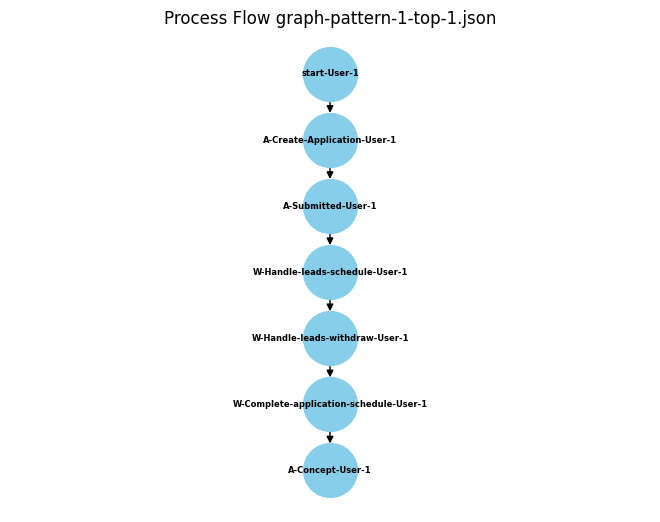

In [31]:
visualize_pattern("graph-pattern-1-top-1.json")

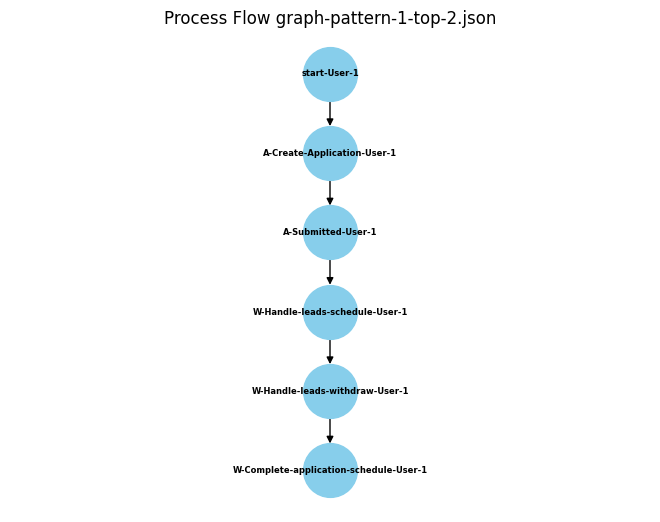

In [32]:
visualize_pattern("graph-pattern-1-top-2.json")

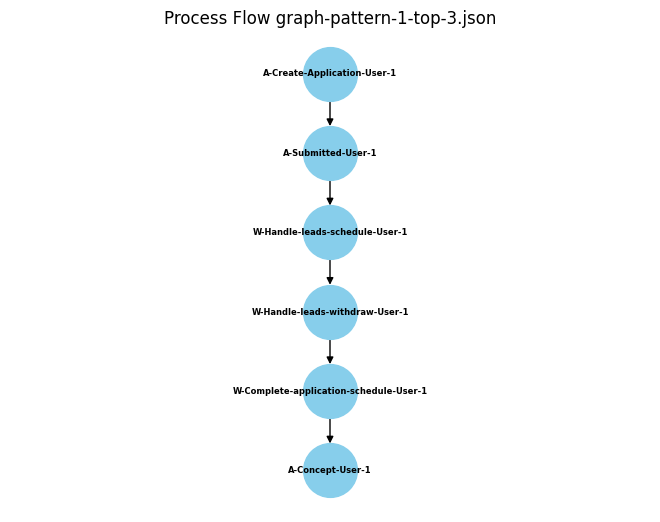

In [33]:
visualize_pattern("graph-pattern-1-top-3.json")